# Neural machine translation with RNN attention model

In this example, we'll use PyTorch to implement GRU-based seq2seq encoder/decoder with Luong attention. We'll use this attention model for French->English neural machine translation.

_This example is based on_ [https://github.com/pytorch/tutorials/blob/master/intermediate_source/seq2seq_translation_tutorial.py](https://github.com/pytorch/tutorials/blob/master/intermediate_source/seq2seq_translation_tutorial.py)

Let's start with the imports and the configuration. The dataset processing is implemented in the `nmt_dataset` module:

In [1]:
import random

import torch
from nmt_dataset import *

DATASET_SIZE = 40000
HIDDEN_SIZE = 128

Next, we'll initialize the device (GPU if available, otherwise CPU):

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Then, we'll implement the `EncoderRNN`, which combines the GRU cell with word embedding layer:

In [3]:
class EncoderRNN(torch.nn.Module):
    """The encoder"""

    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Embedding for the input words
        self.embedding = torch.nn.Embedding(input_size, hidden_size)

        # The actual rnn sell
        self.rnn_cell = torch.nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        """Single sequence encoder step"""

        # Pass through the embedding
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded

        # Pass through the RNN
        output, hidden = self.rnn_cell(output, hidden)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Next, we'll implement the decoder, which includes the attention mechanism:

In [4]:
class AttnDecoderRNN(torch.nn.Module):
    """RNN decoder with attention"""

    def __init__(self, hidden_size, output_size, max_length=MAX_LENGTH, dropout=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length

        # Embedding for the input word
        self.embedding = torch.nn.Embedding(self.output_size, self.hidden_size)

        self.dropout = torch.nn.Dropout(dropout)

        # Attention portion
        self.attn = torch.nn.Linear(in_features=self.hidden_size,
                                    out_features=self.hidden_size)

        self.w_c = torch.nn.Linear(in_features=self.hidden_size * 2,
                                   out_features=self.hidden_size)

        # RNN
        self.rnn_cell = torch.nn.GRU(input_size=self.hidden_size,
                                     hidden_size=self.hidden_size)

        # Output word
        self.w_y = torch.nn.Linear(in_features=self.hidden_size,
                                   out_features=self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # Compute the hidden state at current step t
        rnn_out, hidden = self.rnn_cell(embedded, hidden)

        # Compute the alignment scores
        alignment_scores = torch.mm(self.attn(hidden)[0], encoder_outputs.t())

        # Compute the weights
        attn_weights = torch.nn.functional.softmax(alignment_scores, dim=1)

        # Multiplicative attention context vector c_t
        c_t = torch.mm(attn_weights, encoder_outputs)

        # Concatenate h_t and the context
        hidden_s_t = torch.cat([hidden[0], c_t], dim=1)

        # Compute the hidden context
        hidden_s_t = torch.tanh(self.w_c(hidden_s_t))

        # Compute the output
        output = torch.nn.functional.log_softmax(self.w_y(hidden_s_t), dim=1)

        return output, hidden, attn_weights

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

We'll continue with the training procedure:

In [5]:
def train(encoder, decoder, loss_function, encoder_optimizer, decoder_optimizer, data_loader, max_length=MAX_LENGTH):
    print_loss_total = 0

    # Iterate over the dataset
    for i, (input_tensor, target_tensor) in enumerate(data_loader):
        input_tensor = input_tensor.to(device).squeeze(0)
        target_tensor = target_tensor.to(device).squeeze(0)

        encoder_hidden = encoder.init_hidden()

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        loss = torch.Tensor([0]).squeeze().to(device)

        with torch.set_grad_enabled(True):
            # Pass the sequence through the encoder and store the hidden states at each step
            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(
                    input_tensor[ei], encoder_hidden)
                encoder_outputs[ei] = encoder_output[0, 0]

            # Initiate decoder with the GO_token
            decoder_input = torch.tensor([[GO_token]], device=device)

            # Initiate the decoder with the last encoder hidden state
            decoder_hidden = encoder_hidden

            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                loss += loss_function(decoder_output, target_tensor[di])
                decoder_input = target_tensor[di]  # Teacher forcing

            loss.backward()

            encoder_optimizer.step()
            decoder_optimizer.step()

        print_loss_total += loss.item() / target_length

        it = i + 1
        if it % 1000 == 0:
            print_loss_avg = print_loss_total / 1000
            print_loss_total = 0
            print('Iteration: %d %.1f%%; Loss: %.4f' % (it, 100 * it / len(data_loader.dataset), print_loss_avg))

Next, let's implement the evaluation procedure:

In [6]:
def evaluate(encoder, decoder, input_tensor, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()
        input_tensor.to(device)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            # Pass the sequence through the encoder and store the hidden states at each step
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        # Initiate the decoder with the last encoder hidden state
        decoder_input = torch.tensor([[GO_token]], device=device)  # GO

        # Initiate the decoder with the last encoder hidden state
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        # Generate the output sequence (opposite to teacher forcing)
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data

            # Obtain the output word index with the highest probability
            _, topi = decoder_output.data.topk(1)
            if topi.item() != EOS_token:
                decoded_words.append(dataset.output_lang.index2word[topi.item()])
            else:
                break

            # Use the latest output word as the next input
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

Next, we'll implement a helper function, which allows us to evaluate (translate) random sequence of the training dataset:

In [7]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        sample = random.randint(0, len(dataset.dataset) - 1)
        pair = dataset.pairs[sample]
        input_sequence = dataset[sample][0].to(device)

        output_words, attentions = evaluate(encoder, decoder, input_sequence)

        print('INPUT: %s; TARGET: %s; RESULT: %s' % (pair[0], pair[1], ' '.join(output_words)))

We'll continue with two functions that allows us to see the attention scores over the input sequence:

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluate_and_plot_attention(input_sentence, encoder, decoder):
    input_tensor = dataset.sentence_to_sequence(input_sentence).to(device)

    output_words, attentions = evaluate(encoder=encoder,
                                        decoder=decoder,
                                        input_tensor=input_tensor)

    print('INPUT: %s; OUTPUT: %s' % (input_sentence, ' '.join(output_words)))
    plot_attention(input_sentence, output_words, attentions)

Next, we'll initialize the training dataset:

In [9]:
dataset = NMTDataset('data/eng-fra.txt', DATASET_SIZE)

We'll continue with initializing the encoder/decoder model and the training framework components:

In [11]:
enc = EncoderRNN(dataset.input_lang.n_words, HIDDEN_SIZE).to(device)
dec = AttnDecoderRNN(HIDDEN_SIZE, dataset.output_lang.n_words, dropout=0.1).to(device)

train_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=1,
                                           shuffle=False)

encoder_optimizer = torch.optim.Adam(enc.parameters())
decoder_optimizer = torch.optim.Adam(dec.parameters())
loss_function = torch.nn.NLLLoss()

Finally, we'll can run the training:

In [12]:
train(enc, dec, loss_function, encoder_optimizer, decoder_optimizer, train_loader)

Iteration: 1000 2.5%; Loss: 3.2344
Iteration: 2000 5.0%; Loss: 2.6458
Iteration: 3000 7.5%; Loss: 2.2991
Iteration: 4000 10.0%; Loss: 2.1474
Iteration: 5000 12.5%; Loss: 2.0301
Iteration: 6000 15.0%; Loss: 1.9312
Iteration: 7000 17.5%; Loss: 1.8323
Iteration: 8000 20.0%; Loss: 1.7041
Iteration: 9000 22.5%; Loss: 1.6163
Iteration: 10000 25.0%; Loss: 1.6229
Iteration: 11000 27.5%; Loss: 1.5275
Iteration: 12000 30.0%; Loss: 1.4935
Iteration: 13000 32.5%; Loss: 1.4158
Iteration: 14000 35.0%; Loss: 1.3289
Iteration: 15000 37.5%; Loss: 1.3238
Iteration: 16000 40.0%; Loss: 1.3008
Iteration: 17000 42.5%; Loss: 1.3011
Iteration: 18000 45.0%; Loss: 1.2671
Iteration: 19000 47.5%; Loss: 1.2171
Iteration: 20000 50.0%; Loss: 1.1584
Iteration: 21000 52.5%; Loss: 1.1282
Iteration: 22000 55.0%; Loss: 1.0746
Iteration: 23000 57.5%; Loss: 1.0888
Iteration: 24000 60.0%; Loss: 1.0930
Iteration: 25000 62.5%; Loss: 1.1087
Iteration: 26000 65.0%; Loss: 1.0284
Iteration: 27000 67.5%; Loss: 1.0434
Iteration: 28

Let's see how the model translates some randomly selected sentences:

In [13]:
evaluate_randomly(enc, dec)

INPUT: vous etes merveilleuse .; TARGET: you re wonderful .; RESULT: you re wonderful .
INPUT: c est un bon mari pour moi .; TARGET: he is a good husband to me .; RESULT: he is a good husband to me .
INPUT: c est un tres gentil garcon .; TARGET: he s a very nice boy .; RESULT: he s a very nice boy .
INPUT: je suis tout a fait pour .; TARGET: i m all for that .; RESULT: i m all used to it .
INPUT: je suis deshydratee .; TARGET: i m dehydrated .; RESULT: i m dehydrated .
INPUT: je ne suis pas particulierement impressionnee .; TARGET: i m not particularly impressed .; RESULT: i m not impressed .
INPUT: il est tres flexible .; TARGET: he s very flexible .; RESULT: he s very flexible .
INPUT: desole .; TARGET: i m sorry .; RESULT: i m sorry .
INPUT: c est un de mes voisins .; TARGET: he is one of my neighbors .; RESULT: he s a afraid of my neighbors .
INPUT: il a huit ans .; TARGET: he s eight years old .; RESULT: he is eight years old .


Next, let's visualize the decoder attention over the elements of the input sequence:

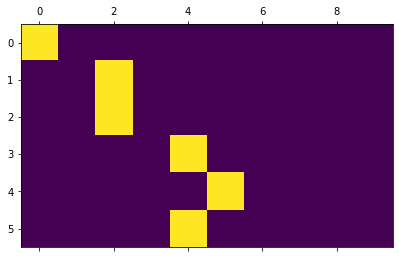

In [14]:
output_words, attentions = evaluate(
    enc, dec, dataset.sentence_to_sequence("je suis trop froid .").to(device))
plt.matshow(attentions.numpy())

Let's see the translation and attention scores with a few more samples:

INPUT: elle a cinq ans de moins que moi .; OUTPUT: she is five years younger than me .


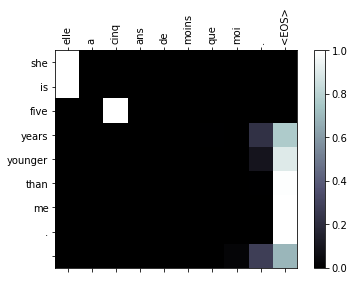

INPUT: elle est trop petit .; OUTPUT: she is too short .


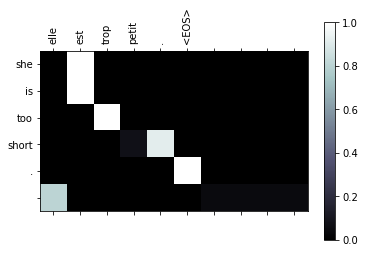

INPUT: je ne crains pas de mourir .; OUTPUT: i m not to die .


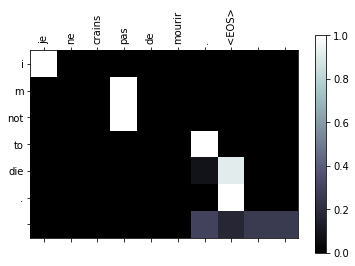

INPUT: c est un jeune directeur plein de talent .; OUTPUT: he s a young person .


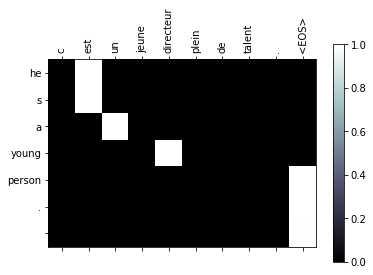

In [15]:
evaluate_and_plot_attention("elle a cinq ans de moins que moi .", enc, dec)

evaluate_and_plot_attention("elle est trop petit .", enc, dec)

evaluate_and_plot_attention("je ne crains pas de mourir .", enc, dec)

evaluate_and_plot_attention("c est un jeune directeur plein de talent .", enc, dec)